In [3]:
import matplotlib, sys,  os
import numpy as np
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from tqdm import tqdm

import healpy as hp
import sys
import os
sys.path.append("/data/home/cwy/Science/3MLWCDA/Standard/src/")
import mylib as my


 11%|█         | 83/768 [00:02<00:18, 37.87it/s]

222 sig_no222.txt not found.


662 sig_no662.txt not found.


712 sig_no712.txt not found.


100%|██████████| 768/768 [00:19<00:00, 39.70it/s]

WARNING UserWarning: Warning: converting a masked element to nan.

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


<Figure size 1920x1440 with 0 Axes>

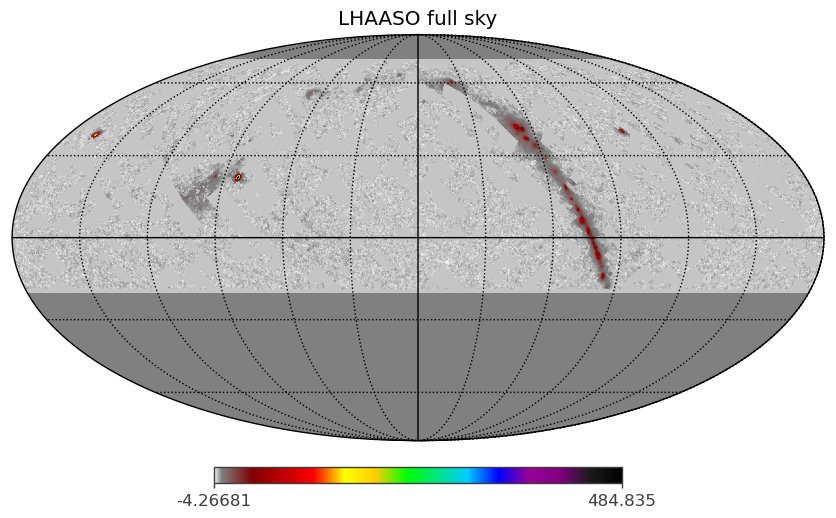

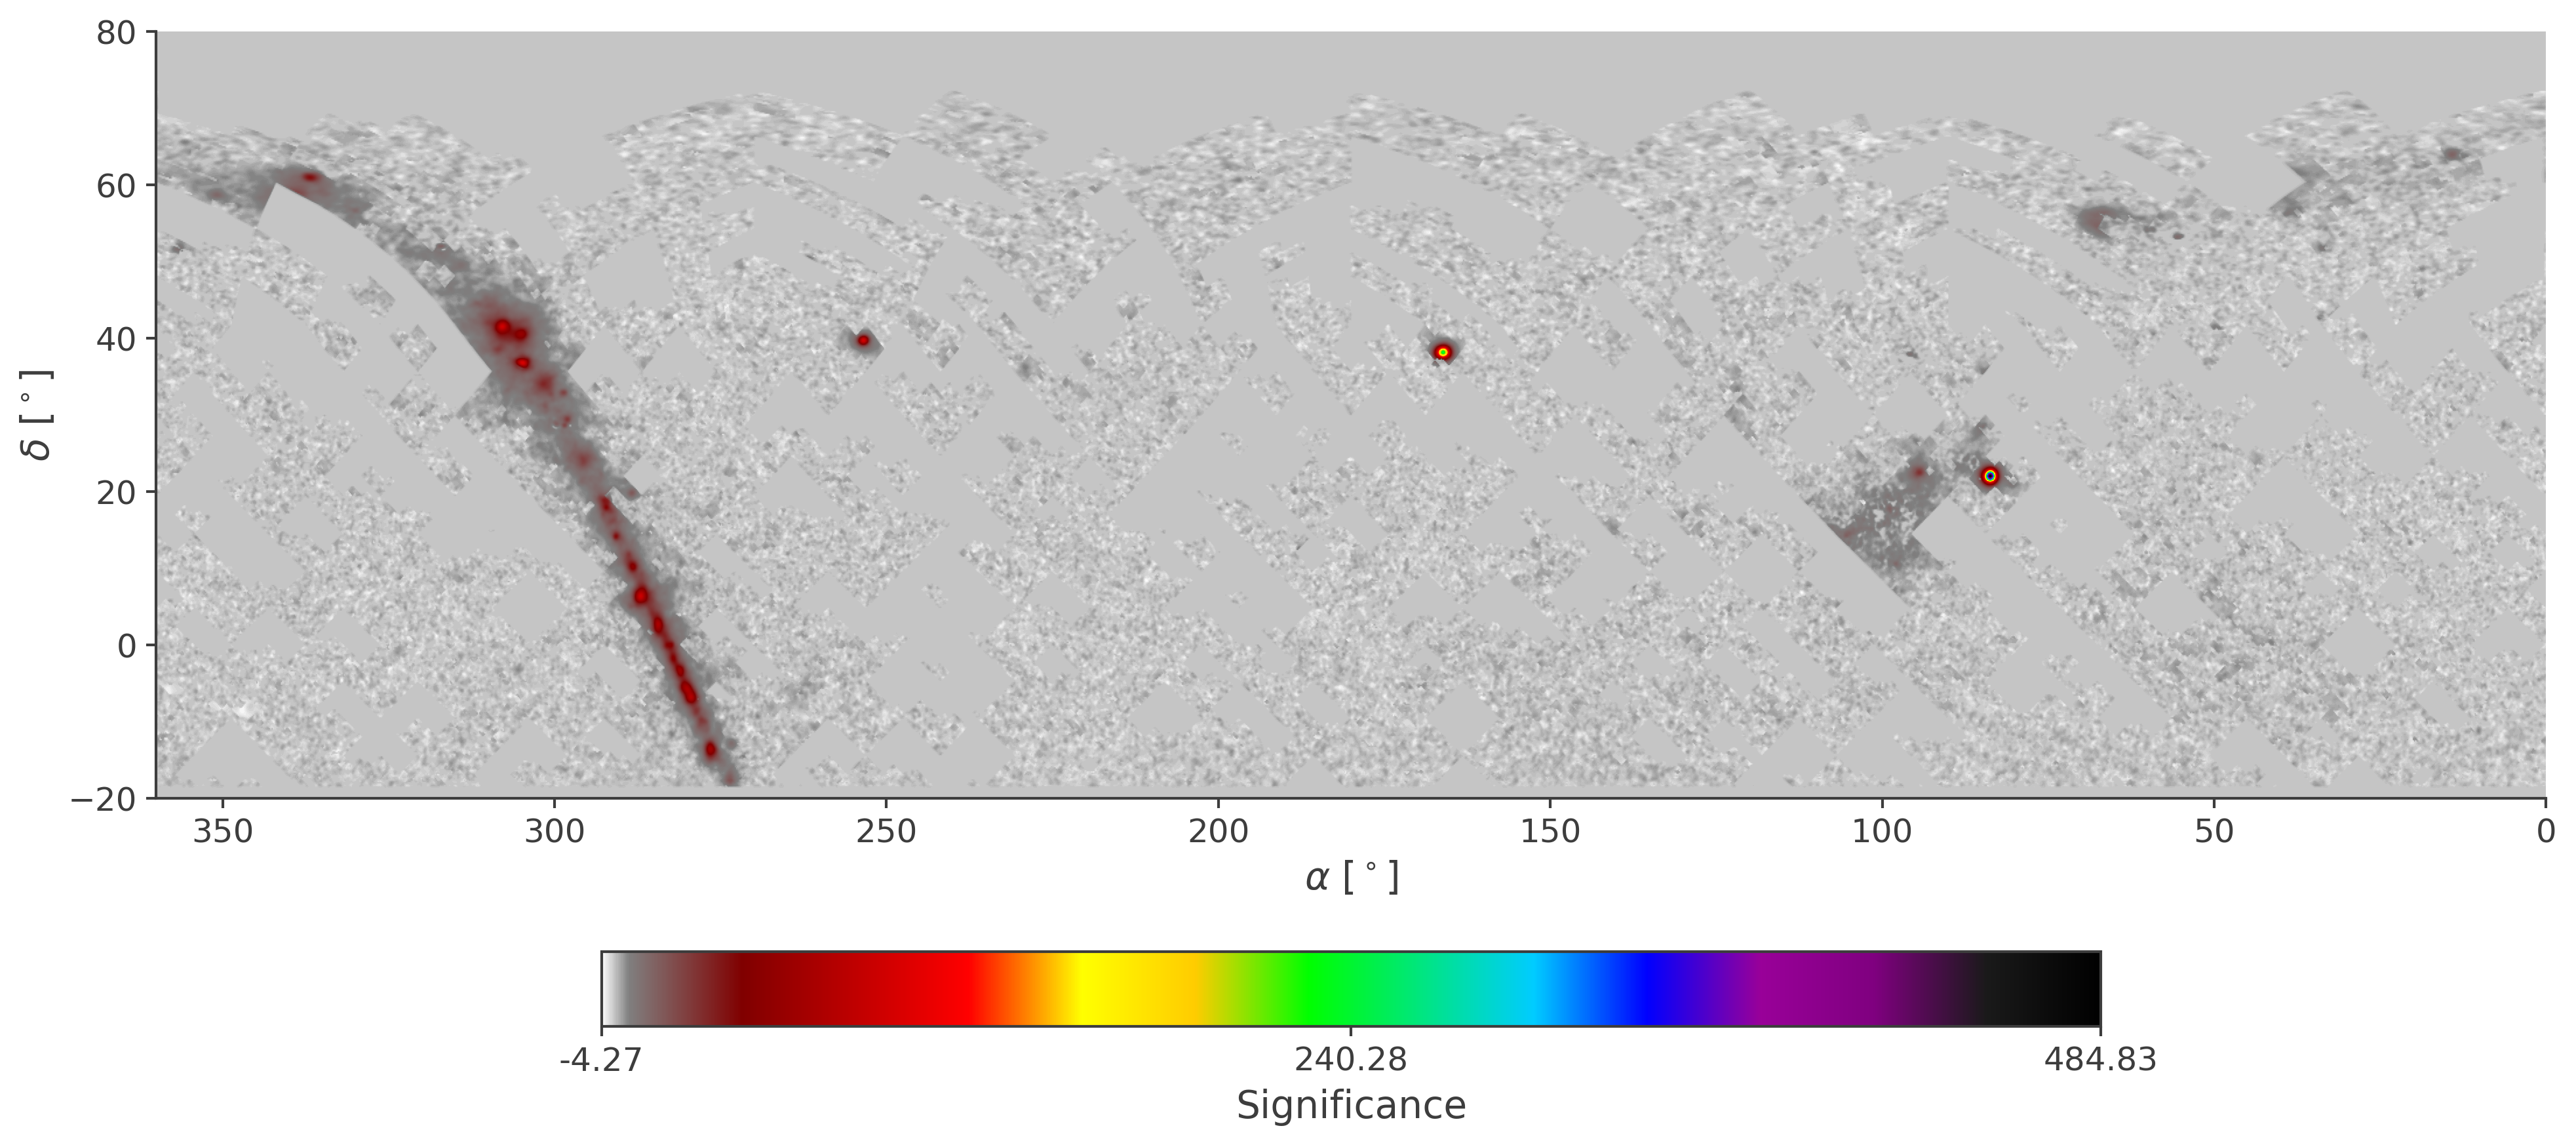

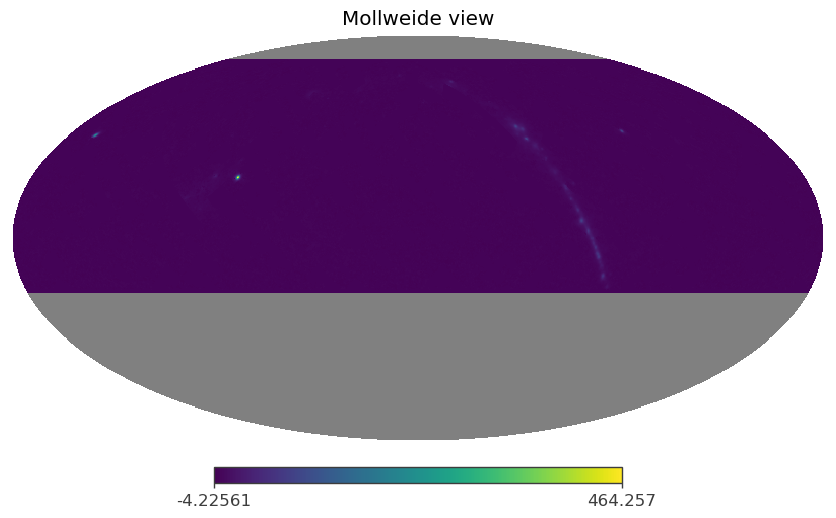

In [4]:
savename="WCDA_KM2A_20240131_LP_TS_fixalpha3"

nside=1024
npix=hp.nside2npix(nside)
skymap=np.zeros(npix)
for i in tqdm(range(768)):
    try:
        data=np.loadtxt(f"sig_no{i}.txt")
    except Exception as e:
        print(i, e)
        continue
    for j in range(len(data)):
        try:
            skymap[int(data[j][0])]=float(data[j][1])
        except Exception as e:
            print(i, e)
            continue
skymap=hp.ma(skymap)
skymap[skymap>0] = np.ma.sqrt(skymap[skymap>0])
skymap[skymap<0] = -np.ma.sqrt(np.abs(skymap[skymap<0]))
%matplotlib inline

my.hpDraw("region_name", "Modelname", skymap,0,0,skyrange=(0,360,-20,80),
            colorlabel="Significance", contours=[100000], save=False, cat={}, color="Milagro", xsize=2048, plotmol=1, savename=savename, dpi=300, threshold=np.sqrt(11.83)) #zmax=30, , zmax=80 , color="Milagro"
plt.savefig(f"fullsky_{savename}.pdf",dpi=300) #{ "TeVCat": [1, "s"], "size": 20,"markercolor": "grey","labelcolor": "grey","angle": 60,"catext": 0 }

nestid = hp.ring2nest(1024, np.arange(hp.nside2npix(1024)))
nestmap=np.zeros(hp.nside2npix(1024))
nestmap[nestid] = skymap
nestmap = hp.ma(nestmap)
hp.mollview(nestmap, nest=1)
hp.write_map(f"fullsky_{savename}.fits.gz",skymap,overwrite=True)
map2 = my.change_coord(skymap,["C","G"])
hp.write_map(f"fullsky_{savename}.fits",map2,overwrite=True)

In [ ]:
hp.mollview(skymap, title="LHAASO full sky", xsize=2048)

In [ ]:
np.ma.max(skymap)

In [ ]:
ss2 = hp.sphtfunc.smoothing(skymap,sigma=np.radians(0.5))

In [ ]:
mapg2 = my.change_coord(ss2,["C","G"])

In [ ]:
my.hpDraw("region_name", "Modelname", mapg2,0,0,skyrange=(0,360,-90,90),
            colorlabel="Significance", contours=[1000], save=False, cat={}, color="Milagro", xsize=2048, plotmol=1, savename=savename) #zmax=30,

In [ ]:
my.hpDraw("region_name", "Modelname", mapg,0,0,skyrange=(0,360,-90,90),
            colorlabel="Significance", contours=[1000], save=False, cat={}, color="Milagro", xsize=2048, plotmol=1, savename=savename) #zmax=30,

In [ ]:
my.hpDraw("region_name", "Modelname", ss2,0,0,skyrange=(0,360,-20,80),
            colorlabel="Significance", contours=[1000], save=False, cat={}, color="Milagro", xsize=2048, plotmol=1, savename=savename) #zmax=30,

In [ ]:
my.hpDraw("region_name", "Modelname", ss2,0,0,skyrange=(0,360,-20,80),
            colorlabel="Significance", contours=[1000], save=False, cat={}, color="Milagro", xsize=2048, plotmol=1, savename=savename) #zmax=30,

In [ ]:
my.hpDraw("region_name", "Modelname", ss2,0,0,skyrange=(0,360,-20,80),
            colorlabel="Significance", contours=[1000], save=False, cat={}, color="Milagro", xsize=2048, plotmol=1, savename=savename) #zmax=30,

In [ ]:
from scipy.optimize import curve_fit
def gaussian(x,a,mu,sigma):
    return a*np.exp(-((x-mu)/sigma)**2/2)
nside=2**10
npix=hp.nside2npix(nside)
pixarea = 4 * np.pi/npix


pixIdx = hp.nside2npix(nside) # number of pixels I can get from this nside
pixIdx = np.arange(pixIdx) # pixel index numbers
new_lats = 90-hp.pix2ang(nside, pixIdx)[0]*180/np.pi # thetas I need to populate with interpolated theta values
new_lons = hp.pix2ang(nside, pixIdx)[1]*180/np.pi # phis, same
mask = (new_lats>15 )  & (new_lats < 20 ) & (new_lons>250) * (new_lons<255)
ra_J0057, dec_J0057 =  14,63.5
ra1,dec1=ra_J0057, dec_J0057

data_radius = 6.0
S = skymap[mask]
S = my.maskdiskout(skymap, ra1, dec1, 6)
bin_y,bin_x,patches = plt.hist(S.compressed(),bins=100)
plt.yscale("log")
plt.xlim(-10,10)
plt.close()
bin_x=np.array(bin_x)
bin_y=np.array(bin_y)
fit_range = np.logical_and(bin_x>-5, bin_x<5)
wdt=(bin_x[1]-bin_x[0])/2.
try:
    popt, pcov = curve_fit(
        gaussian,
        bin_x[fit_range] + wdt,
        bin_y[fit_range[:-1]],
        bounds=([100, -2, 0], [50000000, 2, 10]),
    )
except (ValueError, IndexError):
    popt, pcov = curve_fit(
        gaussian,
        bin_x[:100] + wdt,
        bin_y[:100],
        bounds=([100, -2, 0], [50000000, 2, 10]),
    )
#popt,pcov = curve_fit(gaussian,bin_x[fit_range[0:-1]]+(bin_x[1]-bin_x[0])/2.,bin_y[fit_range[0:-1]],bounds=([100,-2,0],[50000000,2,10]))
print("************************")
print(popt)
print("************************")
print("max Significance= %.1f"%(max(S.compressed())))

plt.figure()
#plt.plot([0.,0.],[1,1e6],'k--',linewidth=0.5)
plt.plot(
    (bin_x[:100] + bin_x[1:101]) / 2,
    gaussian((bin_x[:100] + bin_x[1:101]) / 2, popt[0], 0, 1),
    '--',
    label='expectation',
)
plt.plot((bin_x[:100] + bin_x[1:101]) / 2, bin_y, label="data")
plt.plot(
    (bin_x[:100] + bin_x[1:101]) / 2,
    gaussian((bin_x[:100] + bin_x[1:101]) / 2, popt[0], popt[1], popt[2]),
    '--',
    label='fit',
)
plt.yscale('log')
plt.xlim(-10,10)
plt.ylim(1,max(bin_y*2))
plt.grid(True)
plt.text(-9.5,max(bin_y),'mean = %f\n width = %f'%(popt[1],popt[2]))
plt.xlabel(r'Significance($\sigma$)')
plt.ylabel("entries")
plt.legend()